In [1]:
import os
import gc
import logging
import random
import string
import networkx as nx
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from abc import ABC, abstractmethod
import re
import json
from datetime import datetime


/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ResultsManager:
    def __init__(self, model_path: str, device: str):
        self.run_info = {
            "metadata": {
                "model_path": model_path,
                "device": device,
                "run_timestamp_utc": datetime.utcnow().isoformat() + "Z",
            },
            "experiments": []
        }

    def add_experiment_results(self, name: str, parameters: dict, results_df: pd.DataFrame):
        if results_df.empty:
            return
            
        experiment_data = {
            "name": name,
            "parameters": parameters,
            "results_table": results_df.to_dict(orient='records')
        }
        self.run_info["experiments"].append(experiment_data)

    def add_summary_data(self, name: str, parameters: dict, summary: dict):
        experiment_data = {
            "name": name,
            "parameters": parameters,
            "summary": summary
        }
        self.run_info["experiments"].append(experiment_data)

    def save_to_json(self, filepath: str = "experiment_results.json"):
        with open(filepath, 'w') as f:
            json.dump(self.run_info, f, indent=4)

    def save_to_markdown(self, filepath: str = "experiment_summary.md"):
        with open(filepath, 'w') as f:
            f.write(f"# Experiment Results Summary\n\n")
            f.write(f"**Model Path**: `{self.run_info['metadata']['model_path']}`\n")
            f.write(f"**Timestamp (UTC)**: {self.run_info['metadata']['run_timestamp_utc']}\n")
            f.write(f"**Device**: {self.run_info['metadata']['device']}\n\n")
            f.write("---\n\n")

            for exp in self.run_info['experiments']:
                f.write(f"## {exp['name']}\n\n")
                
                f.write("### Parameters\n\n")
                for key, value in exp['parameters'].items():
                    f.write(f"- **{key.replace('_', ' ').title()}**: {value}\n")
                f.write("\n")

                if "results_table" in exp:
                    f.write("### Results\n\n")
                    df = pd.DataFrame(exp['results_table'])
                    f.write(df.to_markdown(index=False))
                    f.write("\n\n")
                
                if "summary" in exp:
                    f.write("### Summary\n\n")
                    summary_str = json.dumps(exp['summary'], indent=2)
                    f.write(f"```json\n{summary_str}\n```\n\n")
                
                f.write("---\n\n")


In [3]:
# Setup
os.chdir("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = '/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000'
results_manager = ResultsManager(model_path=MODEL_PATH, device=DEVICE)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()


In [4]:
# Graph and task generation utilities
def generate_grid_graph(size=4, direction_map=None):
    if direction_map is None:
        direction_map = {'N': 'NORTH', 'S': 'SOUTH', 'E': 'EAST', 'W': 'WEST'}
    G = nx.DiGraph()
    num_nodes = size * size
    nodes = [f"{chr(97+i)}{chr(97+j)}" for i in range(size) for j in range(size)]
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx+1], direction=direction_map['E'])
            if c > 0: G.add_edge(nodes[idx], nodes[idx-1], direction=direction_map['W'])
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx+size], direction=direction_map['S'])
            if r > 0: G.add_edge(nodes[idx], nodes[idx-size], direction=direction_map['N'])
    return G, nodes, {}

def generate_random_walk(G, start_node, length):
    path = [start_node]
    current_node = start_node
    for _ in range(length - 1):
        neighbors = list(G.successors(current_node))
        if not neighbors: break
        current_node = random.choice(neighbors)
        path.append(current_node)
    return path

def walk_to_string(walk, G):
    if not walk: return ""
    if len(walk) == 1: return walk[0]
    parts = [f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk) - 1)]
    parts.append(walk[-1])
    return " ".join(parts)

def create_foraging_tasks(G, nodes, n_tasks, context_length, **kwargs):
    test_cases = []
    for i in range(n_tasks):
        random_walk_start = random.choice(nodes)
        random_walk_context = generate_random_walk(G, random_walk_start, length=context_length)
        task_info = {
            'name': f'Task {i+1}', 'graph': G, 'task_type': 'foraging',
            'random_walk_context': random_walk_context, 'start': random_walk_context[-1],
            **kwargs
        }
        test_cases.append(task_info)
    return test_cases

def parse_path_with_directions(generated_text: str) -> list[tuple[str, str]]:
    pattern = re.compile(r'\b(NORTH|SOUTH|EAST|WEST)\b\s+\b([a-z]{2})\b')
    return pattern.findall(generated_text)


In [5]:
class ForagingPromptStrategy(ABC):
    @abstractmethod
    def create_prompt(self, task: dict) -> str:
        pass

class InContextStyleForagingStrategy(ForagingPromptStrategy):
    def create_prompt(self, task: dict) -> str:
        return walk_to_string(task['random_walk_context'], task['graph'])

class NavigationGPT:
    def __init__(self, model_path: str):
        logging.info(f"Loading model and tokenizer from: {model_path}")
        if not os.path.isdir(model_path):
            raise FileNotFoundError(f"Model path does not exist: {model_path}")
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
        if self.tokenizer.pad_token is None: 
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_path, torch_dtype=torch.float32)
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.to(DEVICE)
        self.model.eval()
        logging.info(f"Model loaded successfully to {DEVICE}.")

    def generate_path(self, prompt: str, max_new_tokens: int = 60):
        encodings = self.tokenizer(prompt, return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            output_ids = self.model.generate(
                **encodings, max_new_tokens=max_new_tokens, num_beams=1,
                pad_token_id=self.tokenizer.eos_token_id
            )
        prompt_len = encodings.input_ids.shape[1]
        return self.tokenizer.decode(output_ids[0, prompt_len:], skip_special_tokens=False).strip()
    
def get_next_step_logits(prompt: str, model: GPT2LMHeadModel, tokenizer: GPT2TokenizerFast) -> torch.Tensor:
    encodings = tokenizer(prompt, return_tensors='pt').to(DEVICE)
    with torch.no_grad():
        outputs = model(**encodings)
        next_token_logits = outputs.logits[0, -1, :]
    return next_token_logits


In [6]:
def run_evaluation(model_path: str, test_cases: list, prompt_strategy: ForagingPromptStrategy, generation_length: int, debug: bool = False):
    results = []
    try:
        model = NavigationGPT(model_path)
    except Exception as e:
        logging.error(f"FATAL: Could not load model. Aborting. Error: {e}")
        return pd.DataFrame()

    desc = f"Evaluating {os.path.basename(model_path)}"
    for task in tqdm(test_cases, desc=desc):
        prompt = prompt_strategy.create_prompt(task)
        max_new_tokens = generation_length * 3
        generated_text = model.generate_path(prompt, max_new_tokens=max_new_tokens)
        parsed_steps = parse_path_with_directions(generated_text)
        
        is_path_valid = False
        reason_for_invalidity = ""

        if len(parsed_steps) < generation_length:
            reason_for_invalidity = f"Parsing Failure: Expected {generation_length} steps, found {len(parsed_steps)}."
        else:
            is_path_valid = True
            current_node = task['start']
            graph = task['graph']
            for i in range(generation_length):
                direction, next_node = parsed_steps[i]
                if not graph.has_edge(current_node, next_node):
                    is_path_valid = False
                    reason_for_invalidity = f"Invalid Edge (Step {i+1}): Node '{current_node}' has no edge to '{next_node}'."
                    break
                correct_direction = graph.edges[current_node, next_node]['direction']
                if direction != correct_direction:
                    is_path_valid = False
                    reason_for_invalidity = f"Incorrect Direction (Step {i+1}): Path from '{current_node}' to '{next_node}' is '{correct_direction}', not '{direction}'."
                    break
                current_node = next_node
        
        score = 1.0 if is_path_valid else 0.0
        
        if debug and not is_path_valid:
            grid_size = int(np.sqrt(len(task['graph'].nodes())))
            print("\n" + "-"*15 + f" DEBUG: FAILED TASK ({task.get('name')}) " + "-"*15)
            print(f"GRID SIZE          : {grid_size}x{grid_size}")
            print(f"REASON FOR FAILURE : {reason_for_invalidity}")
            print(f"CONTEXT WALK       : {task['random_walk_context']}")
            print(f"PROMPT (ends with) : ...{prompt[-70:]}")
            print(f"GENERATED TEXT     : '{generated_text}'")
            print(f"PARSED STEPS       : {parsed_steps}")
            print("-" * (32 + len(task.get('name', ''))))

        results.append({'accuracy': score})
    
    del model; gc.collect(); torch.cuda.empty_cache()
    return pd.DataFrame(results)


In [7]:
# Configuration
DIRECTIONS_NSWE = {'N': 'NORTH', 'S': 'SOUTH', 'E': 'EAST', 'W': 'WEST'}
MODEL_NAME = "foraging_v1"
PROMPT_STRATEGY = InContextStyleForagingStrategy()
N_TESTS_PER_EXPERIMENT = 300
DEBUG = False
all_results = []


2025-09-22 16:49:27,716 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 16:49:28,129 - INFO - Model loaded successfully to cuda.
Evaluating scheckpoint-73000: 100%|██████████| 500/500 [00:08<00:00, 55.73it/s] 
2025-09-22 16:49:37,199 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 16:49:37,294 - INFO - Model loaded successfully to cuda.
Evaluating scheckpoint-73000: 100%|██████████| 500/500 [00:08<00:00, 57.82it/s]
2025-09-22 16:49:46,037 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 16:49:46,129 - INFO - Model loaded successfully to cuda.
Evaluating scheckpoint-73000: 100%|██████████| 500/500 [00:12<00:00, 40.60it/s]
2025-09-22 16:49:58,538 - INFO - Loading model and tokenizer from: /cs/student/projects1/a

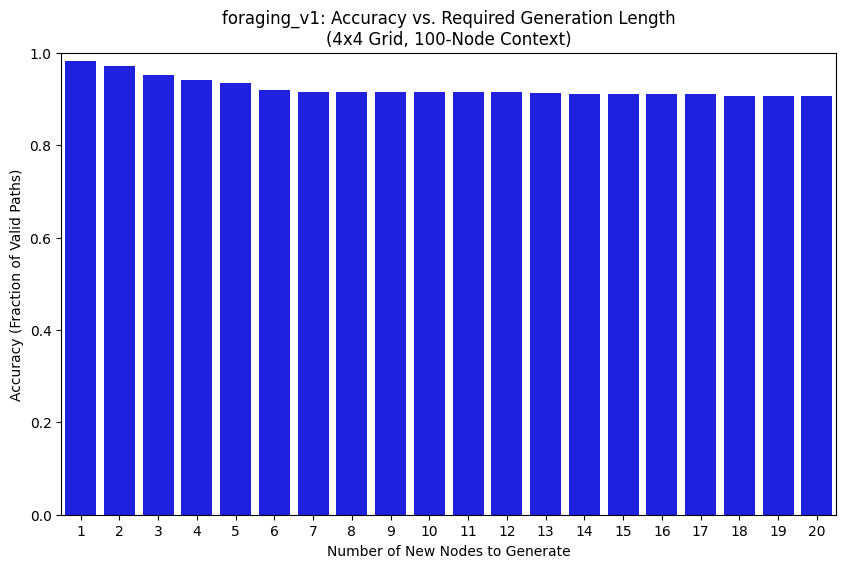

    Generation Length  Accuracy
0                   1     0.982
1                   2     0.972
2                   3     0.952
3                   4     0.942
4                   5     0.934
5                   6     0.920
6                   7     0.916
7                   8     0.916
8                   9     0.916
9                  10     0.916
10                 11     0.916
11                 12     0.914
12                 13     0.912
13                 14     0.910
14                 15     0.910
15                 16     0.910
16                 17     0.910
17                 18     0.906
18                 19     0.906
19                 20     0.906


In [8]:
# Analysis 1: Performance vs Generation Length
GRID_SIZE = 4
CONTEXT_LENGTH = 100
GENERATION_LENGTHS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
N_TESTS = 500

G, nodes, _ = generate_grid_graph(size=GRID_SIZE, direction_map=DIRECTIONS_NSWE)
test_cases = create_foraging_tasks(G, nodes, n_tasks=N_TESTS, context_length=CONTEXT_LENGTH)

results_1 = []
if os.path.isdir(MODEL_PATH):
    for length in GENERATION_LENGTHS:
        temp_results_df = run_evaluation(MODEL_PATH, test_cases, PROMPT_STRATEGY, generation_length=length, debug=DEBUG)
        
        if not temp_results_df.empty:
            accuracy = temp_results_df['accuracy'].mean()
            results_1.append({"Generation Length": length, "Accuracy": accuracy})

    if results_1:
        results_df_1 = pd.DataFrame(results_1)
        results_df_1['Model'] = MODEL_NAME
        results_df_1['Experiment'] = 'Generation Length'
        results_manager.add_experiment_results(
            name="Analysis 1: Performance vs. Generation Length",
            parameters={
                "grid_size": GRID_SIZE,
                "context_length": CONTEXT_LENGTH,
                "num_tasks_per_point": N_TESTS
            },
            results_df=results_df_1
        )
        all_results.append(results_df_1)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=results_df_1, x='Generation Length', y='Accuracy', color='b')
        plt.title(f'{MODEL_NAME}: Accuracy vs. Required Generation Length\n(4x4 Grid, {CONTEXT_LENGTH}-Node Context)')
        plt.xlabel("Number of New Nodes to Generate")
        plt.ylabel("Accuracy (Fraction of Valid Paths)")
        plt.ylim(0, 1)
        plt.show()
        
        print(results_df_1[['Generation Length', 'Accuracy']])


2025-09-22 17:02:55,042 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 17:02:55,118 - INFO - Model loaded successfully to cuda.
Evaluating scheckpoint-73000: 100%|██████████| 500/500 [00:08<00:00, 58.63it/s]
2025-09-22 17:03:03,761 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 17:03:03,843 - INFO - Model loaded successfully to cuda.
Evaluating scheckpoint-73000: 100%|██████████| 500/500 [00:08<00:00, 58.47it/s]
2025-09-22 17:03:12,510 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 17:03:12,600 - INFO - Model loaded successfully to cuda.
Evaluating scheckpoint-73000: 100%|██████████| 500/500 [00:08<00:00, 58.30it/s]
2025-09-22 17:03:21,291 - INFO - Loading model and tokenizer from: /cs/student/projects1/ai

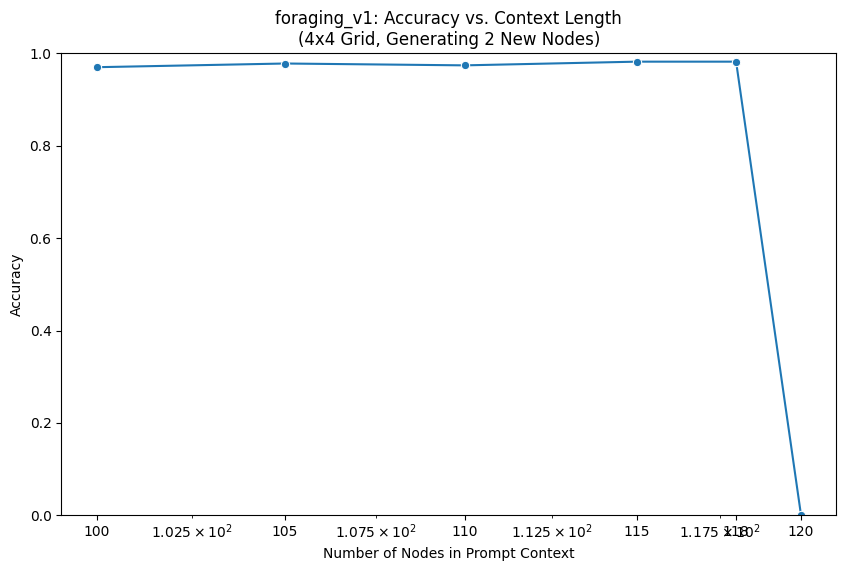

   Context Length  Accuracy
0             100     0.970
1             105     0.978
2             110     0.974
3             115     0.982
4             118     0.982
5             120     0.000


In [9]:
# Analysis 2: Performance vs Context Length
GRID_SIZE = 4
GENERATION_LENGTH = 2
CONTEXT_LENGTHS = [100, 105, 110, 115, 118, 120]
N_TESTS = 500

results_2 = []
if os.path.isdir(MODEL_PATH):
    for context_len in CONTEXT_LENGTHS:
        G, nodes, _ = generate_grid_graph(size=GRID_SIZE, direction_map=DIRECTIONS_NSWE)
        test_cases = create_foraging_tasks(G, nodes, n_tasks=N_TESTS, context_length=context_len)

        temp_results_df = run_evaluation(MODEL_PATH, test_cases, PROMPT_STRATEGY, generation_length=GENERATION_LENGTH, debug=DEBUG)
        
        if not temp_results_df.empty:
            accuracy = temp_results_df['accuracy'].mean()
            results_2.append({"Context Length": context_len, "Accuracy": accuracy})

    if results_2:
        results_df_2 = pd.DataFrame(results_2)
        results_df_2['Model'] = MODEL_NAME
        results_df_2['Experiment'] = 'Context Length'
        all_results.append(results_df_2)
        results_manager.add_experiment_results(
            name="Analysis 2: Performance vs. Context Length",
            parameters={
                "grid_size": GRID_SIZE,
                "generation_length": GENERATION_LENGTH,
                "num_tasks_per_point": N_TESTS
            },
            results_df=results_df_2
        )

        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results_df_2, x='Context Length', y='Accuracy', marker='o')
        plt.title(f'{MODEL_NAME}: Accuracy vs. Context Length\n(4x4 Grid, Generating {GENERATION_LENGTH} New Nodes)')
        plt.xlabel("Number of Nodes in Prompt Context")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.xscale('log')
        plt.xticks(CONTEXT_LENGTHS, labels=CONTEXT_LENGTHS)
        plt.show()
        
        print(results_df_2[['Context Length', 'Accuracy']])


2025-09-22 17:07:11,563 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 17:07:11,648 - INFO - Model loaded successfully to cuda.
Analyzing Ctx Len 115: 100%|██████████| 1000/1000 [00:31<00:00, 32.25it/s]


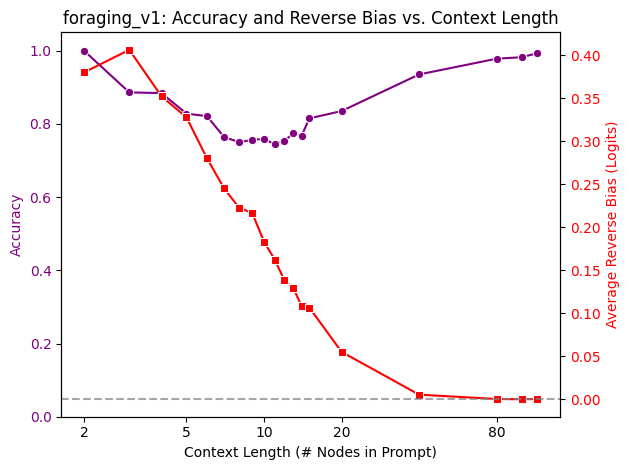

    Context Length  Accuracy  Average Reverse Bias
0                2     1.000              0.379915
1                3     0.886              0.406281
2                4     0.884              0.352261
3                5     0.828              0.327803
4                6     0.821              0.280434
5                7     0.764              0.245191
6                8     0.750              0.222751
7                9     0.756              0.216605
8               10     0.759              0.183354
9               11     0.744              0.162428
10              12     0.754              0.138407
11              13     0.774              0.129319
12              14     0.768              0.108197
13              15     0.815              0.106621
14              20     0.835              0.055244
15              40     0.935              0.005503
16              80     0.978              0.000494
17             100     0.982              0.000184
18             115     0.993   

In [11]:
# Analysis 3: Accuracy and Reverse Bias vs Context Length
GRID_SIZE = 4
CONTEXT_LENGTHS = [2,3,4,5,6,7,8,9,10,11,12,13,14,15, 20, 40, 80, 100, 115]
N_TESTS = 1000

def run_accuracy_and_bias_evaluation(model_path, grid_size, context_lengths, n_tasks, prompt_strategy, direction_map):
    results_data = []
    
    try:
        nav_model = NavigationGPT(model_path)
        model = nav_model.model
        tokenizer = nav_model.tokenizer
    except Exception as e:
        logging.error(f"FATAL: Could not load model. Aborting analysis. Error: {e}")
        return pd.DataFrame()

    # Pre-calculate token IDs for direction words
    direction_token_ids = {
        direction: tokenizer.encode(" " + direction, add_special_tokens=False)[0]
        for direction in direction_map.values()
    }

    for context_len in context_lengths:
        if context_len < 2:
            continue
            
        G, nodes, _ = generate_grid_graph(size=grid_size, direction_map=direction_map)
        test_cases = create_foraging_tasks(G, nodes, n_tasks=n_tasks, context_length=context_len)
        
        accuracies = []
        biases = []

        for task in tqdm(test_cases, desc=f"Analyzing Ctx Len {context_len}"):
            # Calculate Accuracy
            prompt = prompt_strategy.create_prompt(task)
            generated_text = nav_model.generate_path(prompt, max_new_tokens=10)
            parsed_steps = parse_path_with_directions(generated_text)
            
            is_path_valid = False
            if parsed_steps:
                direction, next_node = parsed_steps[0]
                current_node = task['start']
                if G.has_edge(current_node, next_node) and G.edges[current_node, next_node]['direction'] == direction:
                    is_path_valid = True
            
            accuracies.append(1.0 if is_path_valid else 0.0)

            # Calculate Reverse Bias
            walk = task['random_walk_context']
            current_node = walk[-1]
            previous_node = walk[-2]
            
            neighbors = list(G.successors(current_node))
            if not neighbors:
                biases.append(np.nan)
                continue
            
            logits = get_next_step_logits(prompt, model, tokenizer)
            
            reverse_direction = G.edges[current_node, previous_node]['direction']
            reverse_token_id = direction_token_ids[reverse_direction]
            logit_reverse = logits[reverse_token_id].item()
            
            other_directions = [
                G.edges[current_node, neighbor]['direction'] 
                for neighbor in neighbors if neighbor != previous_node
            ]
            
            if not other_directions:
                biases.append(np.nan)
                continue
            
            logits_other = [
                logits[direction_token_ids[direction]].item()
                for direction in other_directions
            ]
            
            mean_logit_other = np.mean(logits_other)
            bias = logit_reverse - mean_logit_other
            biases.append(bias)

        mean_accuracy = np.mean(accuracies)
        mean_bias = np.nanmean(biases)
        
        results_data.append({
            "Context Length": context_len,
            "Accuracy": mean_accuracy,
            "Average Reverse Bias": mean_bias,
        })
        
    del nav_model, model; gc.collect(); torch.cuda.empty_cache()
    return pd.DataFrame(results_data)

if os.path.isdir(MODEL_PATH):
    results_df_3 = run_accuracy_and_bias_evaluation(
        MODEL_PATH, GRID_SIZE, CONTEXT_LENGTHS, N_TESTS, PROMPT_STRATEGY, DIRECTIONS_NSWE
    )

    if not results_df_3.empty:
        results_manager.add_experiment_results(
            name="Analysis 3: Accuracy and Reverse Bias vs. Context Length",
            parameters={"grid_size": GRID_SIZE, "num_tasks_per_point": N_TESTS},
            results_df=results_df_3
        )
        all_results.append(results_df_3)
        
        # Visualization
        fig, ax1 = plt.subplots()
        
        color1 = 'purple'
        color2 = 'red'
        
        sns.lineplot(data=results_df_3, x='Context Length', y='Accuracy', 
                        marker='o', ax=ax1, color=color1)
        ax1.set_xlabel('Context Length (# Nodes in Prompt)')
        ax1.set_ylabel('Accuracy', color=color1)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.set_xscale('log')
        ax1.set_ylim(0, 1.05)
        
        ax2 = ax1.twinx()
        sns.lineplot(data=results_df_3, x='Context Length', y='Average Reverse Bias', 
                        marker='s', ax=ax2, color=color2)
        ax2.set_ylabel('Average Reverse Bias (Logits)', color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
        
        if ax1.get_legend() is not None:
            ax1.get_legend().remove()
        if ax2.get_legend() is not None:
            ax2.get_legend().remove()
        
        x_ticks_to_show = [t for t in CONTEXT_LENGTHS if t in [2, 5, 10, 20, 50, 80, 120]]
        ax1.set_xticks(x_ticks_to_show)
        ax1.set_xticklabels([str(t) for t in x_ticks_to_show])
        ax1.minorticks_off()
        
        plt.title(f"{MODEL_NAME}: Accuracy and Reverse Bias vs. Context Length")
        fig.tight_layout()
        plt.show()
        
        print(results_df_3)


2025-09-22 17:16:22,201 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 17:16:22,290 - INFO - Model loaded successfully to cuda.
Evaluating Node-Only scheckpoint-73000: 100%|██████████| 1/1 [00:00<00:00, 62.22it/s]
2025-09-22 17:16:22,389 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 17:16:22,456 - INFO - Model loaded successfully to cuda.
Evaluating Node-Only scheckpoint-73000: 100%|██████████| 1/1 [00:00<00:00, 61.88it/s]
2025-09-22 17:16:22,554 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 17:16:22,618 - INFO - Model loaded successfully to cuda.
Evaluating Node-Only scheckpoint-73000: 100%|██████████| 1/1 [00:00<00:00, 60.80it/s]
2025-09-22 17:16:22,717 - INFO - Loading model and tokenizer from: /cs/st

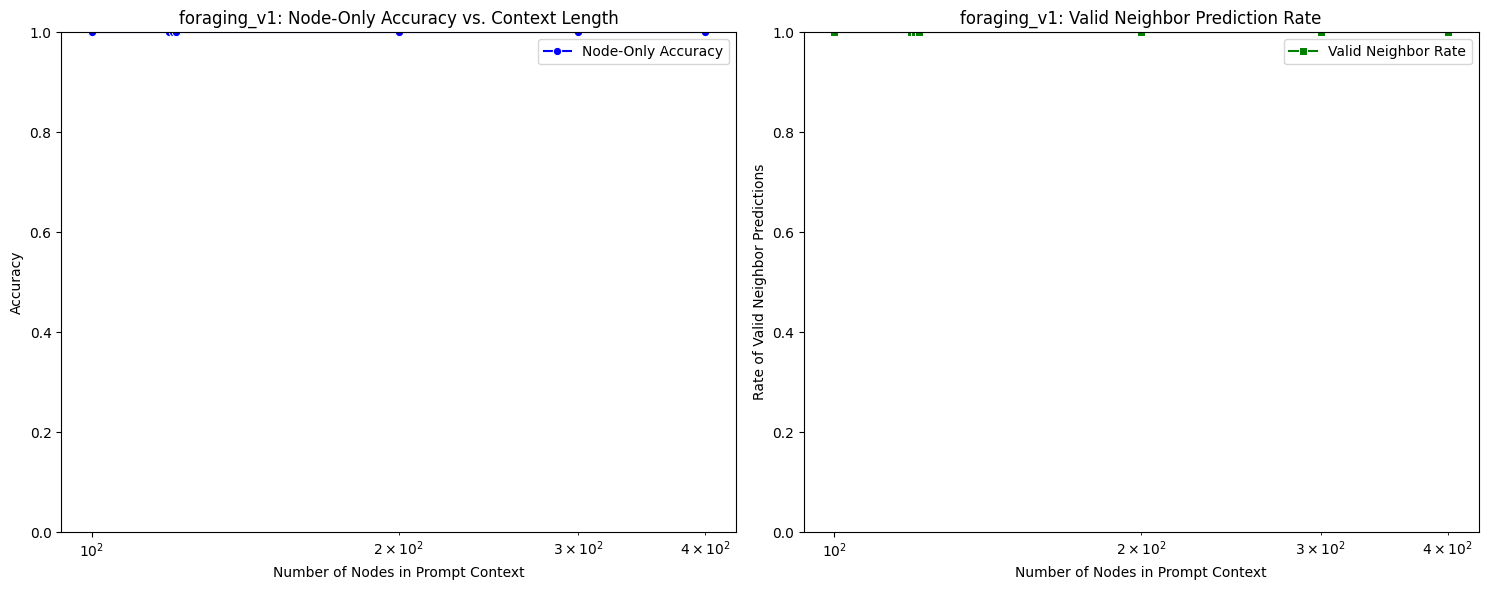

   Context Length  Accuracy  Valid Neighbor Rate
0             100       1.0                  1.0
1             119       1.0                  1.0
2             120       1.0                  1.0
3             121       1.0                  1.0
4             200       1.0                  1.0
5             300       1.0                  1.0
6             400       1.0                  1.0


In [ ]:
# Analysis 4: Node-Only Performance vs Context Length
def create_node_only_foraging_tasks(G, nodes, n_tasks, context_length, **kwargs):
    tasks = []
    max_attempts = n_tasks * 20
    attempts = 0
    
    while len(tasks) < n_tasks and attempts < max_attempts:
        attempts += 1
        
        extended_walk = generate_random_walk(G, random.choice(nodes), length=context_length + 3)
        
        if len(extended_walk) >= context_length + 1:
            context_walk = extended_walk[:context_length]
            current_position = context_walk[-1]
            
            valid_neighbors = list(G.successors(current_position))
            context_nodes_set = set(context_walk)
            valid_context_neighbors = [node for node in valid_neighbors if node in context_nodes_set]
            
            if valid_context_neighbors:
                target_node = random.choice(valid_context_neighbors)
                direction_to_target = G.edges[current_position, target_node]['direction']
                
                context_prompt = walk_to_string(context_walk, G)
                node_only_prompt = f"{context_prompt} {direction_to_target}"
                
                task_info = {
                    'name': f'Node-Only Task {len(tasks) + 1}',
                    'graph': G,
                    'task_type': 'node_only_foraging',
                    'random_walk_context': context_walk,
                    'current_position': current_position,
                    'start': current_position,
                    'target_node': target_node,
                    'node_only_prompt': node_only_prompt,
                    'target_in_context': True,
                    'valid_context_neighbors': valid_context_neighbors,
                    **kwargs
                }
                tasks.append(task_info)
            
    return tasks

class NodeOnlyForagingPromptStrategy(ForagingPromptStrategy):
    def create_prompt(self, task: dict) -> str:
        return task['node_only_prompt']

def parse_node_only_response(generated_text: str) -> str:
    nodes = re.findall(r'\b[a-z]{2}\b', generated_text)
    return nodes[0] if nodes else None

def run_node_only_evaluation(model_path: str, test_cases: list, prompt_strategy: ForagingPromptStrategy, debug: bool = False):
    results = []
    try:
        model = NavigationGPT(model_path)
    except Exception as e:
        logging.error(f"FATAL: Could not load model. Aborting. Error: {e}")
        return pd.DataFrame()

    desc = f"Evaluating Node-Only {os.path.basename(model_path)}"
    for task in tqdm(test_cases, desc=desc):
        prompt = prompt_strategy.create_prompt(task)
        generated_text = model.generate_path(prompt, max_new_tokens=5)
        predicted_node = parse_node_only_response(generated_text)
        
        is_correct = predicted_node == task['target_node']
        is_valid_neighbor = False
        if predicted_node and task['graph'].has_edge(task['start'], predicted_node):
            is_valid_neighbor = True
        
        score = 1.0 if is_correct else 0.0
        
        results.append({
            'accuracy': score,
            'predicted_node': predicted_node,
            'target_node': task['target_node'],
            'is_valid_neighbor': is_valid_neighbor,
            'context_length': len(task['random_walk_context']),
            'target_in_context': task.get('target_in_context', False),
            'num_valid_context_neighbors': len(task.get('valid_context_neighbors', []))
        })
        
    del model; gc.collect(); torch.cuda.empty_cache()
    return pd.DataFrame(results)

# Run node-only analysis
CONTEXT_LENGTHS = [100, 119, 120, 121, 200]
N_TESTS = 1
DEBUG = True

results_4 = []
if os.path.isdir(MODEL_PATH):
    for context_len in CONTEXT_LENGTHS:
        G, nodes, _ = generate_grid_graph(size=4, direction_map=DIRECTIONS_NSWE)
        test_cases = create_node_only_foraging_tasks(G, nodes, n_tasks=N_TESTS, context_length=context_len)
        
        if not test_cases:
            continue
        
        node_only_strategy = NodeOnlyForagingPromptStrategy()
        temp_results_df = run_node_only_evaluation(MODEL_PATH, test_cases, node_only_strategy, debug=DEBUG)
        
        if not temp_results_df.empty:
            accuracy = temp_results_df['accuracy'].mean()
            valid_neighbor_rate = temp_results_df['is_valid_neighbor'].mean()
            
            results_4.append({
                "Context Length": context_len, 
                "Accuracy": accuracy,
                "Valid Neighbor Rate": valid_neighbor_rate,
                "Task Type": "Node Only"
            })

    if results_4:
        results_df_4 = pd.DataFrame(results_4)
        results_df_4['Model'] = MODEL_NAME
        results_df_4['Experiment'] = 'Node-Only Context Length'
        all_results.append(results_df_4)

        results_manager.add_experiment_results(
            name="Analysis 4: Node-Only Performance vs. Context Length",
            parameters={"grid_size": 4, "num_tasks_per_point": N_TESTS},
            results_df=results_df_4
        )
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        sns.lineplot(data=results_df_4, x='Context Length', y='Accuracy', 
                    marker='o', ax=ax1, color='blue', label='Node-Only Accuracy')
        ax1.set_title(f'{MODEL_NAME}: Node-Only Accuracy vs. Context Length')
        ax1.set_xlabel("Number of Nodes in Prompt Context")
        ax1.set_ylabel("Accuracy")
        ax1.set_ylim(0, 1)
        ax1.set_xscale('log')
        ax1.legend()
        
        sns.lineplot(data=results_df_4, x='Context Length', y='Valid Neighbor Rate', 
                    marker='s', ax=ax2, color='green', label='Valid Neighbor Rate')
        ax2.set_title(f'{MODEL_NAME}: Valid Neighbor Prediction Rate')
        ax2.set_xlabel("Number of Nodes in Prompt Context")
        ax2.set_ylabel("Rate of Valid Neighbor Predictions")
        ax2.set_ylim(0, 1)
        ax2.set_xscale('log')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(results_df_4[['Context Length', 'Accuracy', 'Valid Neighbor Rate']])


2025-09-22 17:16:23,653 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000
2025-09-22 17:16:23,721 - INFO - Model loaded successfully to cuda.
Evaluating Hamiltonian Completion scheckpoint-73000: 100%|██████████| 200/200 [00:02<00:00, 78.85it/s]


HAMILTONIAN CYCLE COMPLETION RESULTS
Total tasks: 200
Accuracy (correct completion): 1.0000
Valid neighbor rate: 1.0000
Valid cycle rate: 1.0000
Random baseline: 0.5000
Improvement over random: 2.00x


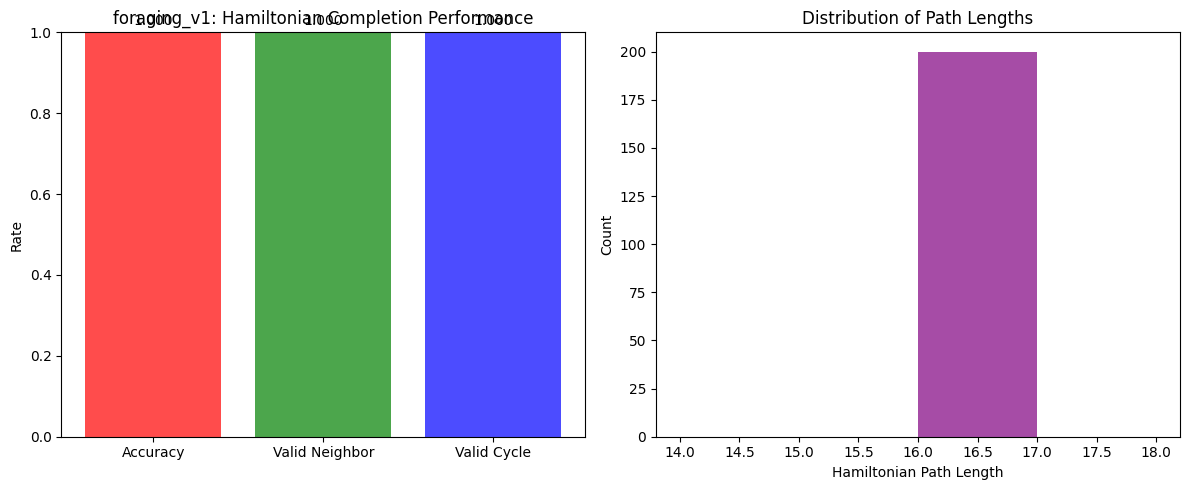

In [13]:
# Analysis 5: Hamiltonian Cycle Completion
def generate_hamiltonian_cycle_task(G, nodes, max_attempts=1000):
    for attempt in range(max_attempts):
        start_node = random.choice(nodes)
        visited = {start_node}
        path = [start_node]
        current = start_node
        
        while len(path) < len(nodes):
            unvisited_neighbors = [n for n in G.successors(current) if n not in visited]
            
            if not unvisited_neighbors:
                break
                
            next_node = random.choice(unvisited_neighbors)
            path.append(next_node)
            visited.add(next_node)
            current = next_node
        
        if len(path) == len(nodes):
            if G.has_edge(current, start_node):
                return path, start_node
    
    return None, None

def create_hamiltonian_completion_tasks(G, nodes, n_tasks, **kwargs):
    tasks = []
    attempts = 0
    max_total_attempts = n_tasks * 100
    
    while len(tasks) < n_tasks and attempts < max_total_attempts:
        attempts += 1
        
        hamiltonian_path, start_node = generate_hamiltonian_cycle_task(G, nodes)
        
        if hamiltonian_path and start_node:
            current_position = hamiltonian_path[-1]
            target_node = start_node
            
            closing_direction = G.edges[current_position, target_node]['direction']
            path_prompt = walk_to_string(hamiltonian_path, G)
            completion_prompt = f"{path_prompt} {closing_direction}"
            
            task_info = {
                'name': f'Hamiltonian-Completion Task {len(tasks) + 1}',
                'graph': G,
                'task_type': 'hamiltonian_completion',
                'hamiltonian_path': hamiltonian_path,
                'current_position': current_position,
                'start': start_node,
                'target_node': target_node,
                'completion_prompt': completion_prompt,
                'closing_direction': closing_direction,
                'path_length': len(hamiltonian_path),
                'visits_all_nodes': len(set(hamiltonian_path)) == len(nodes),
                **kwargs
            }
            tasks.append(task_info)
    
    return tasks

class HamiltonianCompletionPromptStrategy(ForagingPromptStrategy):
    def create_prompt(self, task: dict) -> str:
        return task['completion_prompt']

def run_hamiltonian_completion_evaluation(model_path: str, test_cases: list, prompt_strategy: ForagingPromptStrategy, debug: bool = False):
    results = []
    try:
        model = NavigationGPT(model_path)
    except Exception as e:
        logging.error(f"FATAL: Could not load model. Aborting. Error: {e}")
        return pd.DataFrame()

    desc = f"Evaluating Hamiltonian Completion {os.path.basename(model_path)}"
    for task in tqdm(test_cases, desc=desc):
        prompt = prompt_strategy.create_prompt(task)
        generated_text = model.generate_path(prompt, max_new_tokens=5)
        predicted_node = parse_node_only_response(generated_text)
        
        is_correct = predicted_node == task['target_node']
        
        creates_valid_cycle = False
        if predicted_node:
            cycle_nodes = set(task['hamiltonian_path'] + [predicted_node])
            creates_valid_cycle = len(cycle_nodes) == len(task['graph'].nodes())
        
        is_valid_neighbor = False
        if predicted_node and task['graph'].has_edge(task['current_position'], predicted_node):
            is_valid_neighbor = True
        
        score = 1.0 if is_correct else 0.0
        
        results.append({
            'accuracy': score,
            'predicted_node': predicted_node,
            'target_node': task['target_node'],
            'is_valid_neighbor': is_valid_neighbor,
            'creates_valid_cycle': creates_valid_cycle,
            'path_length': task['path_length'],
            'hamiltonian_path': task['hamiltonian_path']
        })
        
    del model; gc.collect(); torch.cuda.empty_cache()
    return pd.DataFrame(results)

# Run Hamiltonian completion analysis
N_HAMILTONIAN_TESTS = 200
HAMILTONIAN_GRID_SIZE = 4

if os.path.isdir(MODEL_PATH):
    G, nodes, _ = generate_grid_graph(size=HAMILTONIAN_GRID_SIZE, direction_map=DIRECTIONS_NSWE)
    
    hamiltonian_tasks = create_hamiltonian_completion_tasks(G, nodes, n_tasks=N_HAMILTONIAN_TESTS)
    
    if hamiltonian_tasks:
        hamiltonian_strategy = HamiltonianCompletionPromptStrategy()
        results_df_5 = run_hamiltonian_completion_evaluation(
            MODEL_PATH, hamiltonian_tasks, hamiltonian_strategy, debug=DEBUG
        )
        
        if not results_df_5.empty:
            accuracy = results_df_5['accuracy'].mean()
            valid_neighbor_rate = results_df_5['is_valid_neighbor'].mean()
            valid_cycle_rate = results_df_5['creates_valid_cycle'].mean()

            summary_data = {
                "accuracy": accuracy,
                "valid_neighbor_rate": valid_neighbor_rate,
                "valid_cycle_rate": valid_cycle_rate,
                "random_baseline": 1/len(list(G.successors(nodes[0])))
            }
            results_manager.add_summary_data(
                name="Hamiltonian Cycle Completion",
                parameters={"grid_size": HAMILTONIAN_GRID_SIZE, "num_tasks": N_HAMILTONIAN_TESTS},
                summary=summary_data
            )
            
            print(f"HAMILTONIAN CYCLE COMPLETION RESULTS")
            print(f"Total tasks: {len(results_df_5)}")
            print(f"Accuracy (correct completion): {accuracy:.4f}")
            print(f"Valid neighbor rate: {valid_neighbor_rate:.4f}")
            print(f"Valid cycle rate: {valid_cycle_rate:.4f}")
            print(f"Random baseline: {1/len(list(G.successors(nodes[0]))):.4f}")
            print(f"Improvement over random: {accuracy / (1/len(list(G.successors(nodes[0])))):.2f}x")
            
            # Visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            metrics = ['Accuracy', 'Valid Neighbor', 'Valid Cycle']
            values = [accuracy, valid_neighbor_rate, valid_cycle_rate]
            bars = ax1.bar(metrics, values, color=['red', 'green', 'blue'], alpha=0.7)
            ax1.set_ylabel('Rate')
            ax1.set_title(f'{MODEL_NAME}: Hamiltonian Completion Performance')
            ax1.set_ylim(0, 1)
            
            for bar, value in zip(bars, values):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{value:.3f}', ha='center', va='bottom')
            
            ax2.hist(results_df_5['path_length'], bins=range(14, 19), alpha=0.7, color='purple')
            ax2.set_xlabel('Hamiltonian Path Length')
            ax2.set_ylabel('Count')
            ax2.set_title('Distribution of Path Lengths')
            
            plt.tight_layout()
            plt.show()


In [ ]:
class LoopCompletionPromptStrategy(ForagingPromptStrategy):
    """
    Creates a prompt for a loop completion task.
    The prompt is simply the provided text, which is an incomplete loop.
    """
    def create_prompt(self, task: dict) -> str:
        return task['prompt_text']

def generate_name() -> str:
    """Generate a random 2-letter name."""
    return ''.join(random.choices(string.ascii_lowercase, k=2))

def create_loop_completion_tasks(loop_templates: list, n_versions: int = 100):
    """
    Generates multiple versions of loop completion tasks from templates.
    """
    tasks = []
    for i, template in enumerate(loop_templates):
        for j in range(n_versions):
            # The number of unique names needed is one less than the number of placeholders
            num_unique_names = template.count("{}") - 1
            if num_unique_names <= 0: continue
            
            names = [generate_name() for _ in range(num_unique_names)]
            # The full path includes the starting name repeated at the end
            full_path_names = names + [names[0]]
            
            filled_template = template.format(*full_path_names)
            
            # The prompt is the path minus the final node
            prompt_text = " ".join(filled_template.split()[:-1])
            
            tasks.append({
                'name': f'Template {i+1} - Version {j+1}',
                'prompt_text': prompt_text,
                'correct_completion': full_path_names[-1], # The correct answer is the starting node
                'template': template
            })
    return tasks

def run_loop_completion_evaluation(model_path: str, tasks: list, debug: bool = False):
    """
    Runs evaluation for loop completion tasks and returns detailed results.
    """
    results = []
    try:
        model = NavigationGPT(model_path)
    except Exception as e:
        logging.error(f"FATAL: Could not load model. Aborting. Error: {e}")
        return pd.DataFrame()

    prompt_strategy = LoopCompletionPromptStrategy()
    
    for task in tqdm(tasks, desc="Evaluating loop completion"):
        prompt = prompt_strategy.create_prompt(task)
        
        generated_text = model.generate_path(prompt, max_new_tokens=5)
        
        parsed_nodes = re.findall(r'\b[a-z]{2}\b', generated_text)
        
        predicted_node = parsed_nodes[0] if parsed_nodes else None
        is_correct = 1.0 if predicted_node == task['correct_completion'] else 0.0
        
        if debug and not is_correct:
            print("\n" + "-"*15 + f" DEBUG: FAILED LOOP TASK ({task['name']}) " + "-"*15)
            print(f"PROMPT        : {prompt}")
            print(f"EXPECTED      : {task['correct_completion']}")
            print(f"GENERATED     : '{generated_text}'")
            print(f"PREDICTED NODE: {predicted_node}")
            print("-" * (37 + len(task.get('name', ''))))
        
        results.append({
            'accuracy': is_correct,
            'template': task['template']
        })
        
    del model; gc.collect(); torch.cuda.empty_cache()
    return pd.DataFrame(results)

print("Setup for Analyses 5 and 6 complete.")

Setup for Analyses 5 and 6 complete.


2025-09-22 17:28:04,373 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/checkpoint-117000
2025-09-22 17:28:04,457 - INFO - Model loaded successfully to cuda.
Evaluating loop completion: 100%|██████████| 2400/2400 [00:30<00:00, 79.89it/s]


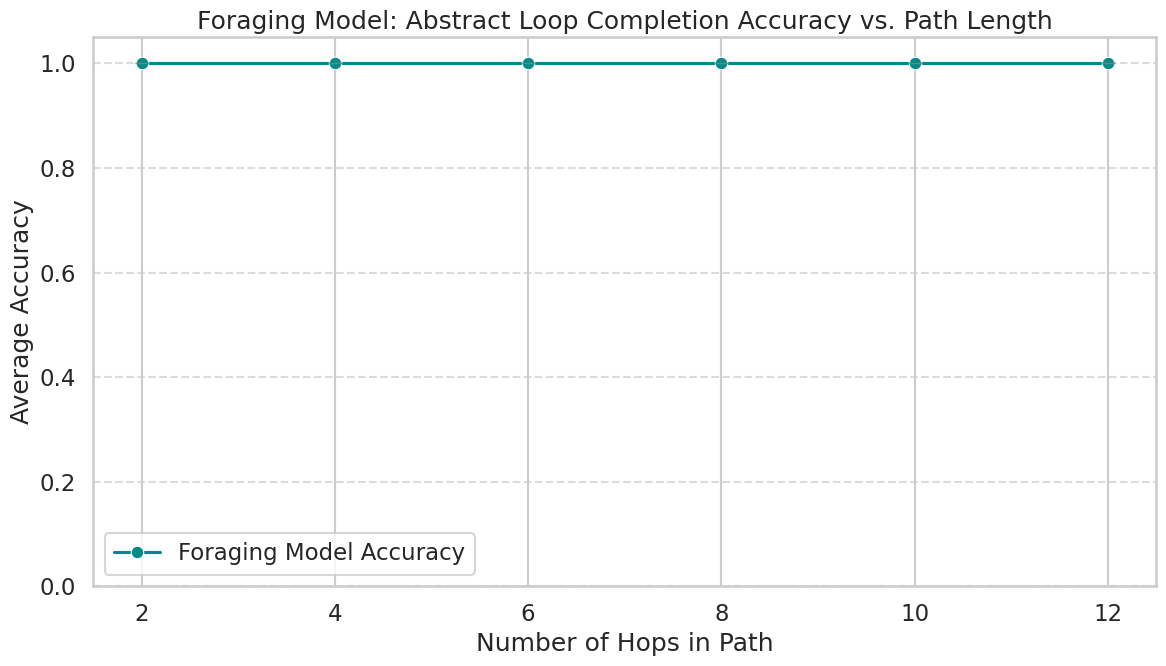

In [22]:
# Analysis 6: Abstract Loop Completion (2-12 Hops)

N_VERSIONS_PER_TEMPLATE = 100

templates_by_hops = {
    2: [
        "{} EAST {} WEST {}", "{} WEST {} EAST {}", "{} NORTH {} SOUTH {}", "{} SOUTH {} NORTH {}",
    ],
    4: [
        "{} EAST {} SOUTH {} WEST {} NORTH {}",
        "{} NORTH {} EAST {} SOUTH {} WEST {}",
        "{} SOUTH {} WEST {} NORTH {} EAST {}",
        "{} WEST {} NORTH {} EAST {} SOUTH {}"
    ],
    6: [
        "{} EAST {} EAST {} NORTH {} WEST {} WEST {} SOUTH {}",
        "{} NORTH {} NORTH {} WEST {} SOUTH {} SOUTH {} EAST {}",
        "{} WEST {} WEST {} SOUTH {} EAST {} EAST {} NORTH {}",
        "{} SOUTH {} SOUTH {} EAST {} NORTH {} NORTH {} WEST {}"
    ],
    8: [
        "{} EAST {} EAST {} EAST {} SOUTH {} WEST {} WEST {} WEST {} NORTH {}",
        "{} SOUTH {} SOUTH {} SOUTH {} EAST {} NORTH {} NORTH {} NORTH {} WEST {}",
        "{} WEST {} WEST {} WEST {} SOUTH {} EAST {} EAST {} EAST {} NORTH {}",
        "{} NORTH {} NORTH {} NORTH {} WEST {} SOUTH {} SOUTH {} SOUTH {} EAST {}"
    ],
    10: [
        "{} EAST {} EAST {} EAST {} SOUTH {} SOUTH {} WEST {} WEST {} WEST {} NORTH {} NORTH {}",
        "{} SOUTH {} SOUTH {} SOUTH {} EAST {} EAST {} NORTH {} NORTH {} NORTH {} WEST {} WEST {}",
        "{} WEST {} WEST {} WEST {} SOUTH {} SOUTH {} EAST {} EAST {} EAST {} NORTH {} NORTH {}",
        "{} NORTH {} NORTH {} NORTH {} WEST {} WEST {} SOUTH {} SOUTH {} SOUTH {} EAST {} EAST {}"
    ],
    12: [
        "{} EAST {} EAST {} EAST {} SOUTH {} SOUTH {} SOUTH {} WEST {} WEST {} WEST {} NORTH {} NORTH {} NORTH {}",
        "{} SOUTH {} SOUTH {} SOUTH {} EAST {} EAST {} EAST {} NORTH {} NORTH {} NORTH {} WEST {} WEST {} WEST {}",
        "{} WEST {} WEST {} WEST {} SOUTH {} SOUTH {} SOUTH {} EAST {} EAST {} EAST {} NORTH {} NORTH {} NORTH {}",
        "{} NORTH {} NORTH {} NORTH {} WEST {} WEST {} WEST {} SOUTH {} SOUTH {} SOUTH {} EAST {} EAST {} EAST {}"
    ]
}

if os.path.isdir(MODEL_PATH):
    all_templates = [template for templates in templates_by_hops.values() for template in templates]
    loop_tasks_5b = create_loop_completion_tasks(all_templates, n_versions=N_VERSIONS_PER_TEMPLATE)
    results_df_5b = run_loop_completion_evaluation(MODEL_PATH, loop_tasks_5b, debug=DEBUG)

    if not results_df_5b.empty:
        get_hops_count = lambda template_str: len(template_str.split()) // 2
        results_df_5b['hops'] = results_df_5b['template'].apply(get_hops_count)

        agg_results_5b = results_df_5b.groupby('hops')['accuracy'].agg(['mean', 'sem']).reset_index()
        
        summary_df_5b = agg_results_5b.rename(columns={'mean': 'Accuracy', 'hops': 'Hops'})
        summary_df_5b['Model'] = MODEL_NAME
        summary_df_5b['Experiment'] = 'Abstract Loop Completion (2-12 Hops)'
        all_results.append(summary_df_5b[['Model', 'Experiment', 'Hops', 'Accuracy']])
        
        results_manager.add_experiment_results(
            name="Analysis 5B: Abstract Loop Completion 2-12 Hops",
            parameters={"num_versions_per_template": N_VERSIONS_PER_TEMPLATE},
            results_df=summary_df_5b
        )

        plt.figure(figsize=(12, 7))
        
        sns.lineplot(data=agg_results_5b, x='hops', y='mean', marker='o', 
                     color='darkcyan', label=f'{MODEL_NAME} Accuracy')
        
        plt.errorbar(agg_results_5b['hops'], agg_results_5b['mean'], yerr=agg_results_5b['sem'],
                     fmt='none', ecolor='gray', capsize=5, alpha=0.7)
        
        plt.xlabel('Number of Hops in Path')
        plt.ylabel('Average Accuracy')
        plt.title(f'{MODEL_NAME}: Abstract Loop Completion Accuracy vs. Path Length')
        plt.xticks(agg_results_5b['hops'])
        plt.ylim(0, 1.05)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

else:
    logging.warning(f"SKIPPING Analysis 5B: Model path not found: {MODEL_PATH}")

2025-09-22 17:31:17,941 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/checkpoint-117000
2025-09-22 17:31:18,020 - INFO - Model loaded successfully to cuda.
Evaluating checkpoint-117000:   0%|          | 0/500 [00:00<?, ?it/s]

Evaluating checkpoint-117000: 100%|██████████| 500/500 [00:04<00:00, 100.90it/s]
2025-09-22 17:31:23,083 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/checkpoint-117000
2025-09-22 17:31:23,151 - INFO - Model loaded successfully to cuda.
Evaluating checkpoint-117000: 100%|██████████| 500/500 [00:04<00:00, 100.62it/s]
2025-09-22 17:31:28,228 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/checkpoint-117000
2025-09-22 17:31:28,301 - INFO - Model loaded successfully to cuda.
Evaluating checkpoint-117000: 100%|██████████| 500/500 [00:04<00:00, 100.41it/s]
2025-09-22 17:31:33,387 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/checkpoint-117000
2025-09-22 17:31:33,461 - INFO - Model loaded successfully to cuda.
Evaluating checkpoint-117000: 100%|██████████| 500/500 [00:05<00:00, 99.86it/s] 
2025-09

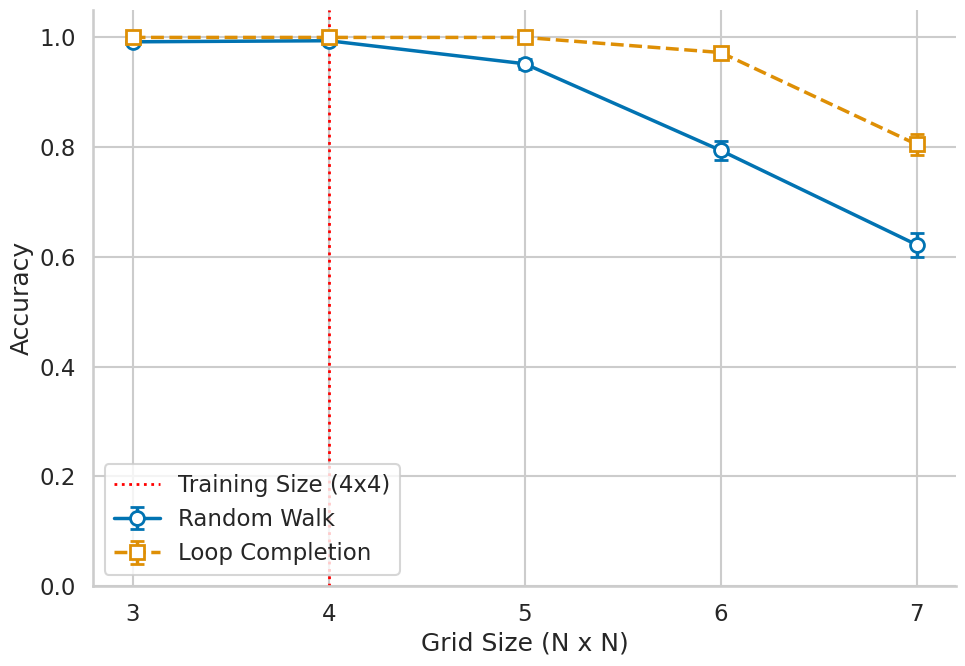

In [24]:
# Analysis 7: Performance vs Grid Size
all_results_df = []

ANALYSIS_3_CONTEXT_LENGTH = 115
ANALYSIS_3_GENERATION_LENGTH = 1
ANALYSIS_3_GRID_SIZES = [3, 4, 5, 6, 7]
N_TESTS_PER_EXPERIMENT_3 = 500

def create_square_loop_templates(n: int):
    if n == 0: return []
    
    directions_map = [
        ('NORTH', 'EAST', 'SOUTH', 'WEST'),
        ('EAST', 'SOUTH', 'WEST', 'NORTH'),
        ('SOUTH', 'WEST', 'NORTH', 'EAST'),
        ('WEST', 'NORTH', 'EAST', 'SOUTH')
    ]
    
    templates = []
    for dirs in directions_map:
        path_dirs = ([dirs[0]] * n) + ([dirs[1]] * n) + ([dirs[2]] * n) + ([dirs[3]] * n)
        template = "{} " + " {} ".join(path_dirs) + " {}"
        templates.append(template)
        
    return templates

results_3 = []
if os.path.isdir(MODEL_PATH):
    for size in ANALYSIS_3_GRID_SIZES:
        G, nodes, _ = generate_grid_graph(size=size, direction_map=DIRECTIONS_NSWE)
        test_cases = create_foraging_tasks(G, nodes, n_tasks=N_TESTS_PER_EXPERIMENT_3, context_length=ANALYSIS_3_CONTEXT_LENGTH)
        temp_results_df = run_evaluation(MODEL_PATH, test_cases, PROMPT_STRATEGY, generation_length=ANALYSIS_3_GENERATION_LENGTH, debug=DEBUG)
        
        if not temp_results_df.empty:
            accuracy = temp_results_df['accuracy'].mean()
            sem = temp_results_df['accuracy'].sem()
            results_3.append({"grid_size": size, "accuracy": accuracy, "sem": sem})

    if results_3:
        df3 = pd.DataFrame(results_3)
        df3['task_type'] = 'Random Walk'
        all_results_df.append(df3)

ANALYSIS_6_MIN_N = 3
ANALYSIS_6_MAX_N = 7
N_TESTS_PER_EXPERIMENT_6 = 100

results_6 = []
if os.path.isdir(MODEL_PATH):
    for n in range(ANALYSIS_6_MIN_N, ANALYSIS_6_MAX_N + 1):
        templates_n = create_square_loop_templates(n - 1)
        if not templates_n: continue
        
        tasks_n = create_loop_completion_tasks(templates_n, n_versions=N_TESTS_PER_EXPERIMENT_6)
        results_df_n = run_loop_completion_evaluation(MODEL_PATH, tasks_n, debug=DEBUG)
        
        if not results_df_n.empty:
            accuracy = results_df_n['accuracy'].mean()
            sem = results_df_n['accuracy'].sem()
            results_6.append({'grid_size': n, 'accuracy': accuracy, 'sem': sem})

    if results_6:
        df6 = pd.DataFrame(results_6)
        df6['task_type'] = 'Loop Completion'
        all_results_df.append(df6)

if all_results_df:
    combined_df = pd.concat(all_results_df, ignore_index=True)
    
    palette = sns.color_palette("colorblind", n_colors=2)
    fig, ax = plt.subplots(figsize=(10, 7))

    task_styles = {
        'Random Walk': {'color': palette[0], 'marker': 'o', 'linestyle': '-'},
        'Loop Completion': {'color': palette[1], 'marker': 's', 'linestyle': '--'}
    }

    for task_type, style in task_styles.items():
        subset = combined_df[combined_df['task_type'] == task_type]
        if not subset.empty:
            ax.errorbar(
                subset['grid_size'], subset['accuracy'], yerr=subset['sem'],
                label=task_type,
                fmt=style['marker'],
                linestyle=style['linestyle'],
                color=style['color'],
                capsize=5,
                markersize=10,
                linewidth=2.5,
                markerfacecolor='white',
                markeredgewidth=2.0
            )

    ax.axvline(x=TRAINING_GRID_SIZE, color='red', linestyle=':', linewidth=2, 
               label=f'Training Size ({TRAINING_GRID_SIZE}x{TRAINING_GRID_SIZE})')
    
    ax.set_xlabel("Grid Size (N x N)")
    ax.set_ylabel("Accuracy")
    ax.set_xticks(range(ANALYSIS_6_MIN_N, ANALYSIS_6_MAX_N + 1))
    ax.set_ylim(0, 1.05)
    
    ax.legend(frameon=True, loc='lower left')
    
    sns.despine(ax=ax)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Save results
results_manager.save_to_json("foraging_v1_results.json")
results_manager.save_to_markdown("foraging_v1_summary.md")

# Combine all results
if all_results:
    combined_results = pd.concat(all_results, ignore_index=True)
    print("\nCombined Results:")
    print(combined_results)



Combined Results:
    Generation Length  Accuracy        Model         Experiment  \
0                 1.0     0.982  foraging_v1  Generation Length   
1                 2.0     0.972  foraging_v1  Generation Length   
2                 3.0     0.952  foraging_v1  Generation Length   
3                 4.0     0.942  foraging_v1  Generation Length   
4                 5.0     0.934  foraging_v1  Generation Length   
5                 6.0     0.920  foraging_v1  Generation Length   
6                 7.0     0.916  foraging_v1  Generation Length   
7                 8.0     0.916  foraging_v1  Generation Length   
8                 9.0     0.916  foraging_v1  Generation Length   
9                10.0     0.916  foraging_v1  Generation Length   
10               11.0     0.916  foraging_v1  Generation Length   
11               12.0     0.914  foraging_v1  Generation Length   
12               13.0     0.912  foraging_v1  Generation Length   
13               14.0     0.910  foraging_v